In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
from pathlib import Path
from time import strftime, gmtime

from typing import Tuple

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
# Student number
np.random.seed(16896375)

In [4]:
PROJECT_DIR = Path("..")
DATA_DIR = PROJECT_DIR / "data"

ILIDS_META_DIR = DATA_DIR / "ilids-metadata"

# Videos

In [5]:
videos_csv = ILIDS_META_DIR / "videos.csv"

videos_df = pd.read_csv(videos_csv, index_col="format.filename")

In [6]:
def seconds2minutes(seconds: int) -> str:
    return f"{(seconds // 60):02.0f}:{(seconds % 60):02.0f}"

In [7]:
def bin_between_min_max(df: pd.DataFrame, *, bins=None, nb_bins: int = 12) -> Tuple:
    if bins is None:
        min, max = df.min(), df.max()
        bins = np.logspace(
            math.log10(min) if min > 0 else 0.0, math.log10(max), nb_bins, endpoint=True
        )

    bins = pd.cut(df, bins=bins)
    ax = bins.value_counts(sort=False).plot.bar(rot=0)
    ax.bar_label(ax.containers[0], padding=2)

    return bins, ax

# Video durations

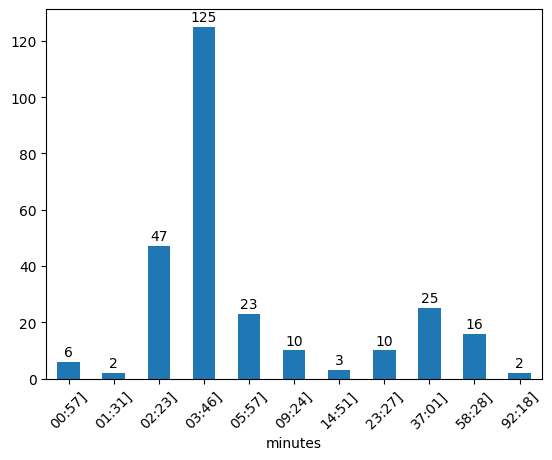

In [8]:
durations = videos_df["stream.duration"].sort_values()

bins, ax = bin_between_min_max(durations)
ax.set_xticklabels(
    [f"{seconds2minutes(c.right)}]" for c in bins.cat.categories], rotation=45
)
ax.set_xlabel("minutes")
plt.show()

# Alarms

In [9]:
alarms_csv = ILIDS_META_DIR / "alarms.csv"

alarms_df = pd.read_csv(alarms_csv, index_col="filename")

alarms_df["AlarmDuration"] = pd.to_timedelta(alarms_df["AlarmDuration"])
alarms_df["StartTime"] = pd.to_timedelta(alarms_df["StartTime"])

## Alarm Duration

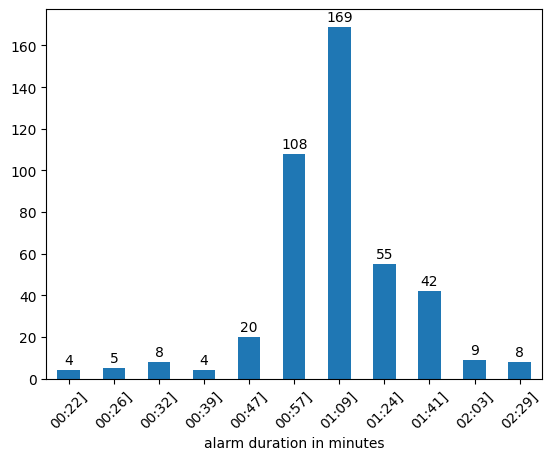

In [10]:
alarm_durations = alarms_df["AlarmDuration"].sort_values()

bins, ax = bin_between_min_max(alarm_durations.dt.seconds)
ax.set_xticklabels(
    [f"{seconds2minutes(c.right)}]" for c in bins.cat.categories], rotation=45
)
ax.set_xlabel("alarm duration in minutes")
plt.show()

## Alarm Distance
Like the difficulty to catch the perturbation/action

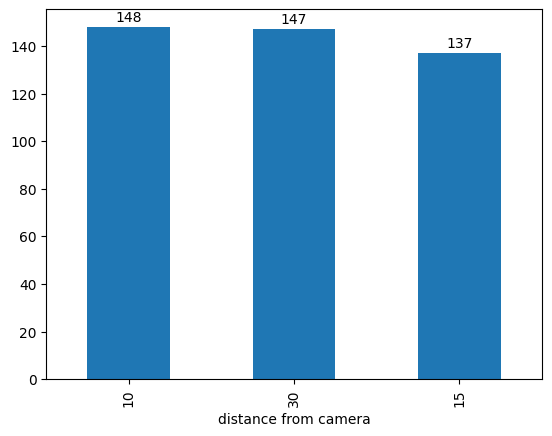

In [11]:
alarm_distance = alarms_df["Distance"]

ax = alarm_distance.value_counts().plot.bar()
ax.bar_label(ax.containers[0], padding=2)
ax.set_xlabel("distance from camera")
plt.show()

## Alarm Start Time

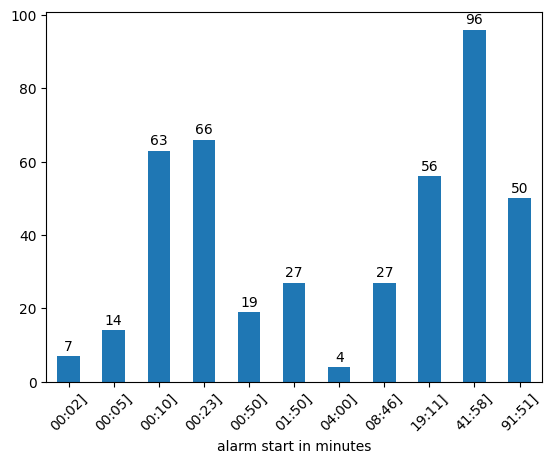

In [12]:
alarm_start = alarms_df["StartTime"].sort_values()

bins, ax = bin_between_min_max(alarm_start.dt.seconds)
ax.set_xticklabels(
    [f"{seconds2minutes(c.right)}]" for c in bins.cat.categories], rotation=45
)
ax.set_xlabel("alarm start in minutes")
plt.show()

## Alarm Start Time x to Video Duration

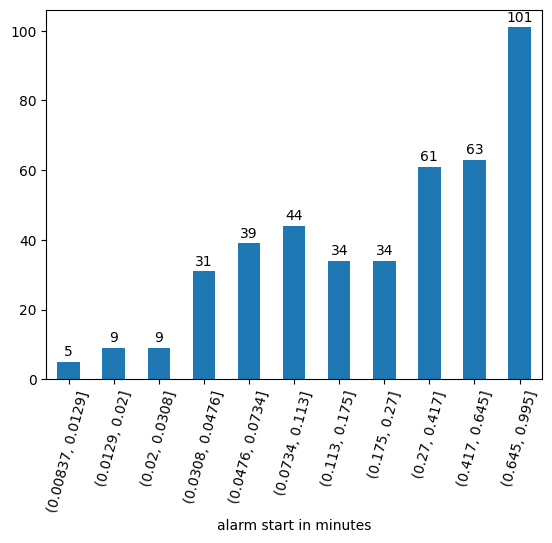

In [13]:
duration_x_start_df = durations.to_frame().join(alarm_start.dt.seconds)

duration_x_start_df["relative_start"] = (
    duration_x_start_df["StartTime"] / duration_x_start_df["stream.duration"]
)
# not every video has alarms
duration_x_start_df = duration_x_start_df.dropna()

bins, ax = bin_between_min_max(duration_x_start_df["relative_start"])
ax.set_xticklabels([str(c) for c in bins.cat.categories], rotation=75)
ax.set_xlabel("alarm start in minutes")
plt.show()

# Handcrafted Timed Distractions
Will be part of the **False Positive** given to the model to lure it.

Additionally, sequences with "nothing"/background will also be fed to the model.

In [14]:
hand_distractions_csv = (
    DATA_DIR / "handcrafted-metadata" / "szte_distractions.extended.csv"
)

hand_distractions_df = pd.read_csv(hand_distractions_csv, index_col="filename")
hand_distractions_df.index = "SZTE/video/" + hand_distractions_df.index

hand_distractions_df["start time"] = pd.to_datetime(hand_distractions_df["start time"])
hand_distractions_df["end time"] = pd.to_datetime(hand_distractions_df["end time"])
hand_distractions_df["duration"] = (
    hand_distractions_df["end time"] - hand_distractions_df["start time"]
)

## Distractions Duration

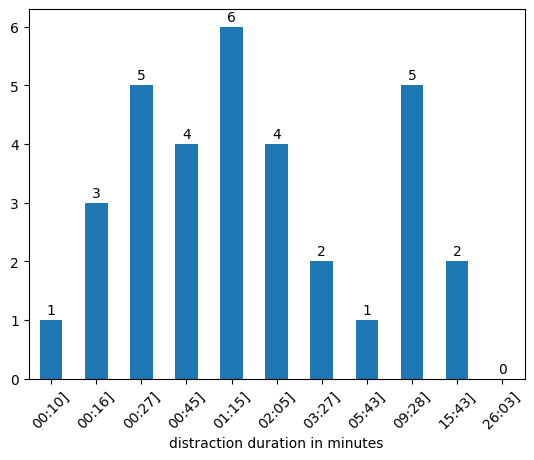

In [15]:
distraction_durations = hand_distractions_df["duration"].sort_values()

bins, ax = bin_between_min_max(distraction_durations.dt.seconds)
ax.set_xticklabels(
    [f"{seconds2minutes(c.right)}]" for c in bins.cat.categories], rotation=45
)
ax.set_xlabel("distraction duration in minutes")
plt.show()

## Distractions Start Time

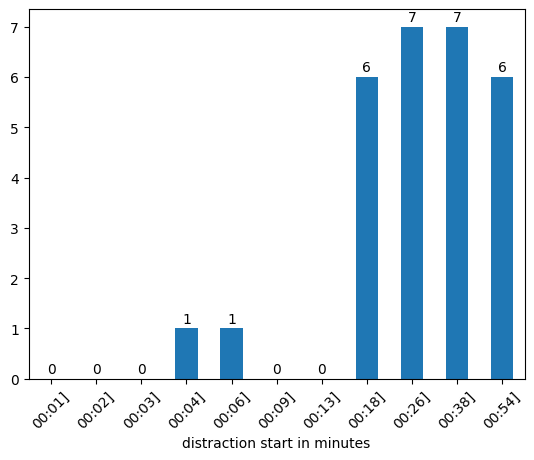

In [16]:
distraction_start = hand_distractions_df["start time"].sort_values()

bins, ax = bin_between_min_max(distraction_start.dt.second)
ax.set_xticklabels(
    [f"{seconds2minutes(c.right)}]" for c in bins.cat.categories], rotation=45
)
ax.set_xlabel("distraction start in minutes")
plt.show()

# Mix Alarm and Distraction duration

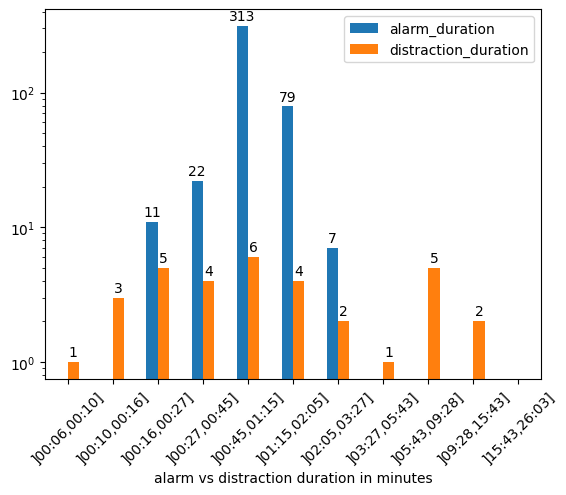

In [17]:
# distraction_durations = hand_distractions_df["duration"].sort_values()
# alarm_durations = alarms_df["AlarmDuration"].sort_values()

alarm_durations_min = alarm_durations.dt.seconds.min()
duration_min = min(distraction_durations.dt.seconds.min(), alarm_durations_min)

alarm_duration_max = alarm_durations.dt.seconds.max()
distraction_duration_max = distraction_durations.dt.seconds.max()
duration_max = max(distraction_duration_max, alarm_duration_max)

bins = np.logspace(
    math.log10(duration_min) if duration_min > 0 else 0.0,
    math.log10(duration_max),
    12,
    endpoint=True,
)

distraction_bins = pd.cut(distraction_durations.dt.seconds, bins=bins)
alarm_bins = pd.cut(alarm_durations.dt.seconds, bins=bins)

ax = (
    alarm_bins.value_counts(sort=False)
    .to_frame(name="alarm_duration")
    .join(
        distraction_bins.value_counts(sort=False).to_frame(name="distraction_duration")
    )
    .plot.bar(rot=0)
)

ax.set_xticklabels(
    [
        f"]{seconds2minutes(c.left)},{seconds2minutes(c.right)}]"
        for c in distraction_bins.cat.categories
    ],
    rotation=45,
)
ax.set_xlabel("alarm vs distraction duration in minutes")
ax.set_yscale("log")

for container in ax.containers:
    ax.bar_label(container, padding=2)
plt.show()

In [18]:
distraction_durations

filename
SZTE/video/SZTEN102d.mov   0 days 00:00:06
SZTE/video/SZTEA102b.mov   0 days 00:00:08
SZTE/video/SZTEN101c.mov   0 days 00:00:12
SZTE/video/SZTEN102d.mov   0 days 00:00:14
SZTE/video/SZTEN102d.mov   0 days 00:00:14
SZTE/video/SZTEA204a.mov   0 days 00:00:20
SZTE/video/SZTEN101a.mov   0 days 00:00:21
SZTE/video/SZTEN202c.mov   0 days 00:00:21
SZTE/video/SZTEN201a.mov   0 days 00:00:22
SZTE/video/SZTEA201b.mov   0 days 00:00:25
SZTE/video/SZTEN202d.mov   0 days 00:00:28
SZTE/video/SZTEA101a.mov   0 days 00:00:29
SZTE/video/SZTEN201a.mov   0 days 00:00:32
SZTE/video/SZTEN201d.mov   0 days 00:00:41
SZTE/video/SZTEA104a.mov   0 days 00:00:49
SZTE/video/SZTEN101b.mov   0 days 00:00:50
SZTE/video/SZTEN102a.mov   0 days 00:01:01
SZTE/video/SZTEN102a.mov   0 days 00:01:04
SZTE/video/SZTEN101a.mov   0 days 00:01:10
SZTE/video/SZTEN101d.mov   0 days 00:01:13
SZTE/video/SZTEN102b.mov   0 days 00:01:20
SZTE/video/SZTEN101b.mov   0 days 00:01:22
SZTE/video/SZTEN201b.mov   0 days 00:01:45
SZ

In [19]:
distraction_duration_max, alarm_duration_max

(1563, 149)

### Conclusion

Some distraction might be way too long (10x longer).

Therefore, pick part of the distraction inside its interval


### Fixing distractions length


In [20]:
distractions_to_shorten = hand_distractions_df.loc[
    hand_distractions_df["duration"].dt.seconds > alarm_duration_max
].copy()

In [21]:
new_durations = np.random.randint(
    alarm_durations_min, alarm_duration_max, len(distractions_to_shorten)
)
relative_new_starts = (
    (1 - alarm_duration_max / distraction_duration_max) * 0.95
) * np.random.random(len(distractions_to_shorten))

np.column_stack((new_durations, relative_new_starts))

array([[8.30000000e+01, 4.85053042e-02],
       [2.80000000e+01, 1.19645646e-01],
       [8.90000000e+01, 8.29058536e-01],
       [3.30000000e+01, 8.06273309e-01],
       [3.60000000e+01, 4.41439042e-01],
       [1.21000000e+02, 5.95758119e-01],
       [5.80000000e+01, 6.12005235e-01],
       [1.20000000e+02, 3.91552346e-01],
       [8.80000000e+01, 3.38612326e-01],
       [6.20000000e+01, 8.02762661e-01]])

In [22]:
distractions_to_shorten["start time"]

filename
SZTE/video/SZTEN101b.mov   2023-05-18 00:22:25
SZTE/video/SZTEN101c.mov   2023-05-18 00:00:00
SZTE/video/SZTEN101d.mov   2023-05-18 00:00:00
SZTE/video/SZTEN101d.mov   2023-05-18 00:08:17
SZTE/video/SZTEN102a.mov   2023-05-18 00:04:29
SZTE/video/SZTEN201c.mov   2023-05-18 00:00:00
SZTE/video/SZTEN201d.mov   2023-05-18 00:00:00
SZTE/video/SZTEN202a.mov   2023-05-18 00:03:15
SZTE/video/SZTEN202b.mov   2023-05-18 00:16:14
SZTE/video/SZTEN202c.mov   2023-05-18 00:04:40
Name: start time, dtype: datetime64[ns]

In [23]:
distractions_to_shorten["start time"] + distractions_to_shorten["duration"]

filename
SZTE/video/SZTEN101b.mov   2023-05-18 00:25:01
SZTE/video/SZTEN101c.mov   2023-05-18 00:15:42
SZTE/video/SZTEN101d.mov   2023-05-18 00:05:12
SZTE/video/SZTEN101d.mov   2023-05-18 00:15:28
SZTE/video/SZTEN102a.mov   2023-05-18 00:12:12
SZTE/video/SZTEN201c.mov   2023-05-18 00:26:03
SZTE/video/SZTEN201d.mov   2023-05-18 00:07:08
SZTE/video/SZTEN202a.mov   2023-05-18 00:10:24
SZTE/video/SZTEN202b.mov   2023-05-18 00:29:47
SZTE/video/SZTEN202c.mov   2023-05-18 00:10:35
dtype: datetime64[ns]

In [24]:
new_durations_delta = pd.to_timedelta(new_durations, unit="second")
new_durations_delta

TimedeltaIndex(['0 days 00:01:23', '0 days 00:00:28', '0 days 00:01:29',
                '0 days 00:00:33', '0 days 00:00:36', '0 days 00:02:01',
                '0 days 00:00:58', '0 days 00:02:00', '0 days 00:01:28',
                '0 days 00:01:02'],
               dtype='timedelta64[ns]', freq=None)

In [25]:
new_start = (
    distractions_to_shorten["start time"] + new_durations_delta * relative_new_starts
)
new_end = new_start + new_durations_delta

In [26]:
assert (distractions_to_shorten["start time"] <= new_start).all()
assert (distractions_to_shorten["end time"] >= new_end).all()

In [27]:
new_hand_distractions_df = hand_distractions_df.copy()

new_hand_distractions_df.loc[
    new_hand_distractions_df["duration"].dt.seconds > alarm_duration_max, "start time"
] = new_start.dt.floor("S")
new_hand_distractions_df.loc[
    new_hand_distractions_df["duration"].dt.seconds > alarm_duration_max, "end time"
] = new_end.dt.floor("S")
new_hand_distractions_df.loc[
    new_hand_distractions_df["duration"].dt.seconds > alarm_duration_max, "duration"
] = pd.to_timedelta(new_durations, unit="second").floor("S")

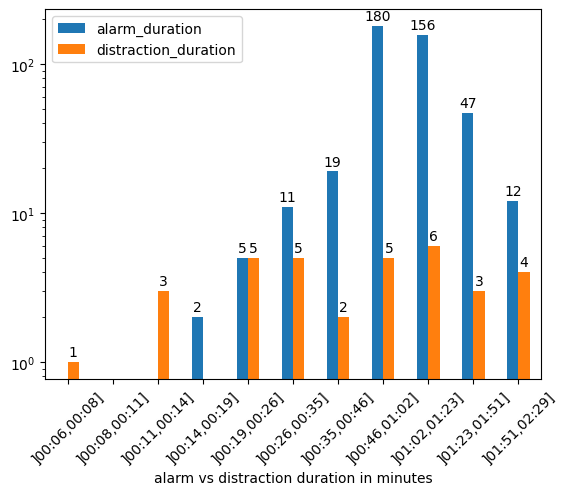

In [28]:
new_distraction_durations = new_hand_distractions_df["duration"].sort_values()
# alarm_durations = alarms_df["AlarmDuration"].sort_values()

alarm_durations_min = alarm_durations.dt.seconds.min()
duration_min = min(new_distraction_durations.dt.seconds.min(), alarm_durations_min)

alarm_duration_max = alarm_durations.dt.seconds.max()
distraction_duration_max = new_distraction_durations.dt.seconds.max()
duration_max = max(distraction_duration_max, alarm_duration_max)

bins = np.logspace(
    math.log10(duration_min) if duration_min > 0 else 0.0,
    math.log10(duration_max),
    12,
    endpoint=True,
)

distraction_bins = pd.cut(new_distraction_durations.dt.seconds, bins=bins)
alarm_bins = pd.cut(alarm_durations.dt.seconds, bins=bins)

ax = (
    alarm_bins.value_counts(sort=False)
    .to_frame(name="alarm_duration")
    .join(
        distraction_bins.value_counts(sort=False).to_frame(name="distraction_duration")
    )
    .plot.bar(rot=0)
)

ax.set_xticklabels(
    [
        f"]{seconds2minutes(c.left)},{seconds2minutes(c.right)}]"
        for c in distraction_bins.cat.categories
    ],
    rotation=45,
)
ax.set_xlabel("alarm vs distraction duration in minutes")
ax.set_yscale("log")

for container in ax.containers:
    ax.bar_label(container, padding=2)
plt.show()

In [29]:
# Change to way time related column will be serialized in the new csv
new_hand_distractions_df["start time"] = new_hand_distractions_df[
    "start time"
].dt.strftime("%H:%M:%S")
new_hand_distractions_df["end time"] = new_hand_distractions_df["end time"].dt.strftime(
    "%H:%M:%S"
)
new_hand_distractions_df["duration"] = new_hand_distractions_df[
    "duration"
].dt.seconds.apply(lambda secs: strftime("%H:%M:%S", gmtime(secs)))

new_hand_distractions_df.sort_index().to_csv(
    hand_distractions_csv.parent / f"{hand_distractions_csv.stem}.corrected.csv"
)